In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import sklearn
import sqlite3
import matplotlib

import numpy as np
import pandas as pd
import enchant as en
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)
%aimport data
from data import make_dataset as md

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['legend.markerscale'] = 3
matplotlib.rcParams['font.size'] = 16.0

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [8]:
spell_check = en.Dict('en_US')

In [3]:
DIR = os.getcwd() + "/../data/"
df = pd.read_csv(DIR + 'raw/lending-club-loan-data/loan.csv', low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean, impute missing values


In [5]:
t = md.clean_data(df)
t.head()

Now cleaning data.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,171.62,NaT,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,119.66,NaT,2013-09-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,649.91,NaT,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,357.48,NaT,2015-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,67.79,2016-02-01,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [6]:
t2 = md.impute_missing(t)
t2.head()

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:2824: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,171.62,NaT,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,119.66,NaT,2013-09-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,649.91,NaT,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,357.48,NaT,2015-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,67.79,2016-02-01,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


In [9]:
s = 'my spej is bad'
string_list = str(s).split()
errors_list = [spell_check.check(x) for x in string_list]
errors_list

[True, False, True, True]

In [14]:
float(errors_list.count(False)) / len(errors_list)

0.25

In [16]:
t2.select_dtypes(include = ['object']).head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,Jan-1985,f,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,Apr-1999,f,INDIVIDUAL
2,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,Nov-2001,f,INDIVIDUAL
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,other,personel,917xx,CA,Feb-1996,f,INDIVIDUAL
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,other,Personal,972xx,OR,Jan-1996,f,INDIVIDUAL


In [19]:
t3 = md.spelling_mistakes(t2)
t3.head()

Now calculating spelling mistakes.
This may take a while.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,emp_title_percent_misspelled,title_percent_misspelled
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1.0,0.0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,2013-09-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0.0,0.0
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,1.0,0.0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,2015-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0.0,1.0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,2016-01-01,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,0.0,0.0


In [20]:
t3[['emp_title', 'emp_title_percent_misspelled', 'title', 'title_percent_misspelled']].head()

,emp_title,emp_title_percent_misspelled,title,title_percent_misspelled
0,NaN,1.0,Computer,0.0
1,Ryder,0.0,bike,0.0
2,NaN,1.0,real estate business,0.0
3,AIR RESOURCES BOARD,0.0,personel,1.0
4,University Medical Group,0.0,Personal,0.0


In [22]:
t3[['emp_title_percent_misspelled', 'title_percent_misspelled']].describe()

,emp_title_percent_misspelled,title_percent_misspelled
count,884766.000000,884766.000000
mean,0.174831,0.021598
std,0.335104,0.128298
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.200000,0.000000
max,1.000000,1.000000


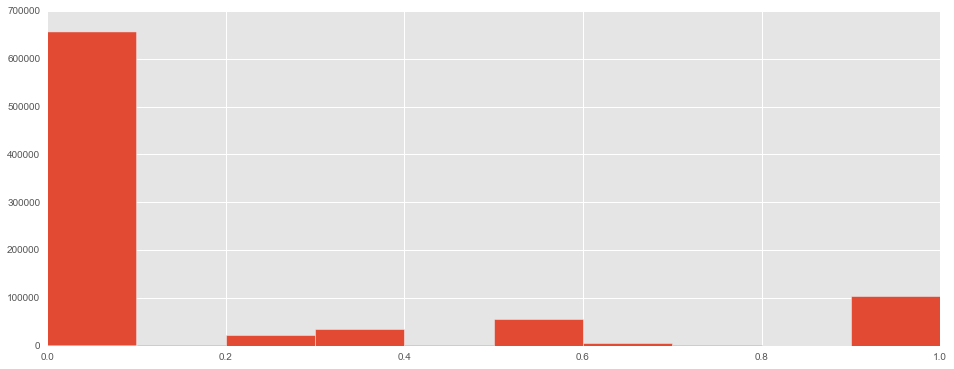

In [25]:
plt.hist(t3['emp_title_percent_misspelled'], label = 'Employee title')
plt.hist(t3['title_percent_misspelled'], label = Title')
plt.show()

#### Imputing missing values: `float64`

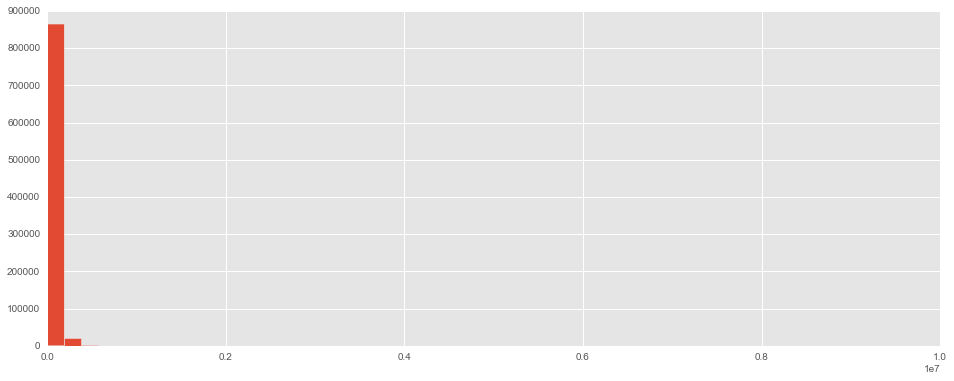

In [25]:
plt.hist(df['annual_inc'].dropna(), bins = 50)
plt.show()

In [52]:
# Drop the people making over $400k a year
df2 = df[df['annual_inc'] <= 400000].copy()
df2.shape, df.shape

((885412, 74), (887379, 74))

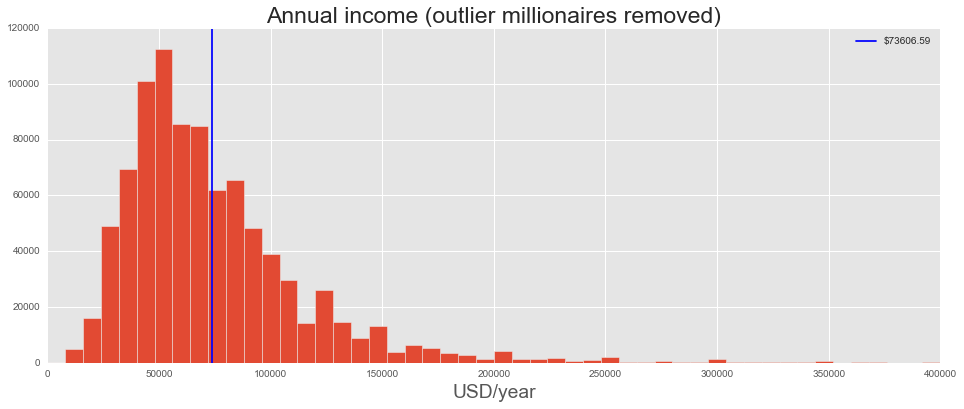

In [58]:
plt.hist(df2['annual_inc'], bins = 50)
plt.axvline(df2['annual_inc'].mean(), label = "${:.2f}".format(df2['annual_inc'].mean()))
plt.title('Annual income (outlier millionaires removed)')
plt.xlabel('USD/year')
plt.legend()
plt.show()

In [63]:
# Since it's just 25 out of 800k, I'll drop
df2['delinq_2yrs'].value_counts(dropna = False)
df3 = df2[df2['delinq_2yrs'].isnull() == False]
df3.shape, df2.shape

((885387, 74), (885412, 74))

In [67]:
df3['inq_last_6mths'].isnull().value_counts()

False    885387
Name: inq_last_6mths, dtype: int64

In [72]:
df3['revol_util'].isnull().value_counts()

False    884920
True        467
Name: revol_util, dtype: int64

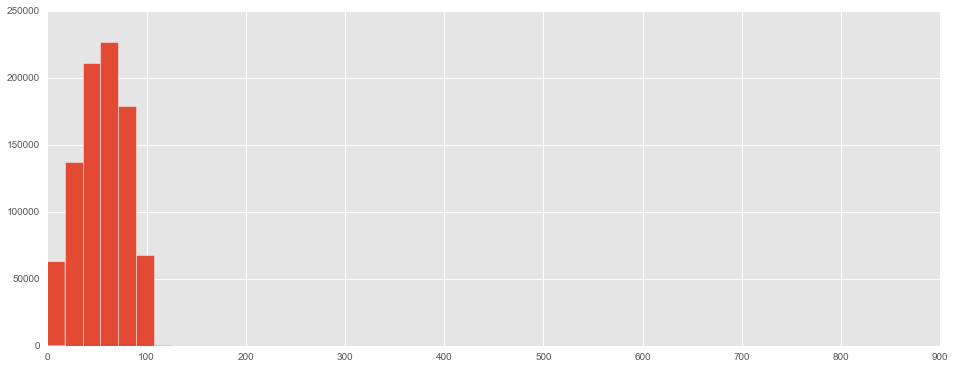

In [76]:
plt.hist(df3['revol_util'].dropna(), bins = 50)
plt.show()

In [83]:
float(df3[df3['revol_util'] > 100].shape[0]) / df3.shape[0]
# Let's drop people using > 100% their credit rate

df4 = df3[df3['revol_util'] <= 130].copy()
df4.shape, df3.shape

((884878, 74), (885387, 74))

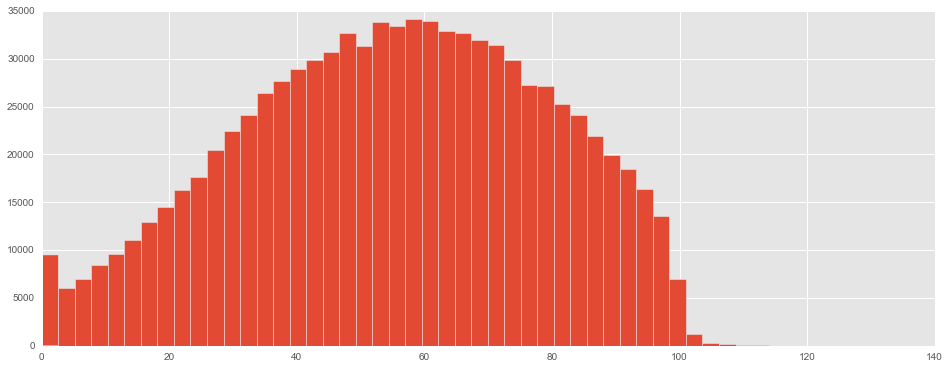

In [84]:
df4['revol_util'].hist(bins = 50)

In [90]:
df5 = df4[df4['collections_12_mths_ex_med'].isnull() == False].copy()
df5.shape, df4.shape

((884766, 74), (884878, 74))

In [105]:
# Imputing using the mean
df5['tot_coll_amt'].fillna(value = df5['tot_coll_amt'].mean(), inplace = True)

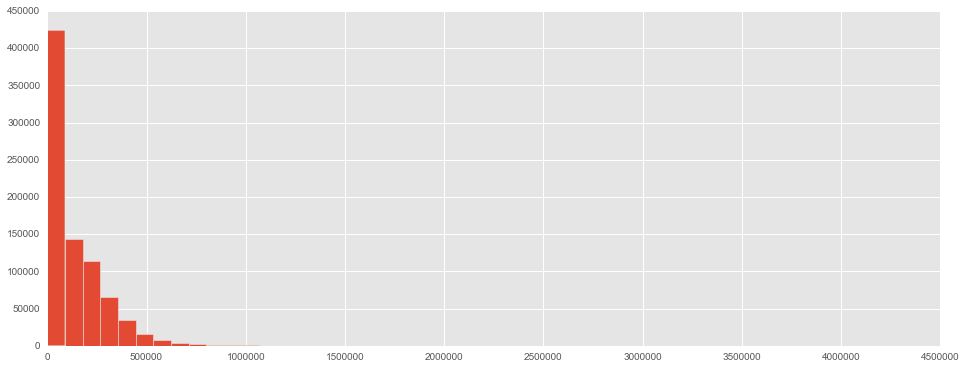

In [110]:
df5['tot_cur_bal'].hist(bins = 50)

In [115]:
df5[df5['tot_cur_bal'].isnull() == True][cols_to_keep].tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
230652,1062400,1294262,20500.0,20500.0,20500.0,36 months,16.77,728.54,D,D2,...,10.21,NaN,Nov-2015,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN
230653,1059394,1291010,15000.0,15000.0,15000.0,36 months,15.27,521.97,C,C4,...,541.95,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN
230654,1059224,1290827,35000.0,35000.0,35000.0,36 months,15.96,1229.81,C,C5,...,1244.72,NaN,Dec-2014,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN
230655,1058722,1290521,12000.0,12000.0,12000.0,36 months,16.29,423.61,D,D1,...,423.61,NaN,Sep-2012,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN
230656,1058291,1289878,12000.0,7775.0,7775.0,60 months,15.27,186.08,C,C4,...,186.08,Feb-2016,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,225.960795,NaN,NaN


In [116]:
# I think it makes sense to set these to zero - these are people who's current balance is NaN
# because their loan is finished/paid off
df5['tot_cur_bal'].fillna(value = 0, inplace = True)

In [8]:
# Let's just drop this column
cols_to_keep.remove('total_rev_hi_lim')
len(cols_to_keep)

52

In [10]:
print cols_to_keep

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal']


In [ ]:
for i in cols_to_keep:
    if df5[i]

In [5]:
df['emp_title'].apply(lambda x: spell_check.check(x)).value_counts() / len(df['emp_title'])

False    0.801466
True     0.198534
Name: emp_title, dtype: float64

In [18]:
df[objects].head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-2011,Fully Paid,n,...,credit_card,Computer,860xx,AZ,Jan-1985,f,Jan-2015,NaN,Jan-2016,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-2011,Charged Off,n,...,car,bike,309xx,GA,Apr-1999,f,Apr-2013,NaN,Sep-2013,INDIVIDUAL
2,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-2011,Fully Paid,n,...,small_business,real estate business,606xx,IL,Nov-2001,f,Jun-2014,NaN,Jan-2016,INDIVIDUAL
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-2011,Fully Paid,n,...,other,personel,917xx,CA,Feb-1996,f,Jan-2015,NaN,Jan-2015,INDIVIDUAL
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-2011,Current,n,...,other,Personal,972xx,OR,Jan-1996,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
5,36 months,A,A4,Veolia Transportaton,3 years,RENT,Source Verified,Dec-2011,Fully Paid,n,...,wedding,My wedding loan I promise to pay back,852xx,AZ,Nov-2004,f,Jan-2015,NaN,Sep-2015,INDIVIDUAL
6,60 months,C,C5,Southern Star Photography,8 years,RENT,Not Verified,Dec-2011,Current,n,...,debt_consolidation,Loan,280xx,NC,Jul-2005,f,Jan-2016,Feb-2016,Jan-2016,INDIVIDUAL
7,36 months,E,E1,MKC Accounting,9 years,RENT,Source Verified,Dec-2011,Fully Paid,n,...,car,Car Downpayment,900xx,CA,Jan-2007,f,Jan-2015,NaN,Dec-2014,INDIVIDUAL
8,60 months,F,F2,NaN,4 years,OWN,Source Verified,Dec-2011,Charged Off,n,...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,Apr-2004,f,Apr-2012,NaN,Aug-2012,INDIVIDUAL
9,60 months,B,B5,Starbucks,< 1 year,RENT,Verified,Dec-2011,Charged Off,n,...,other,Building my credit history.,774xx,TX,Sep-2004,f,Nov-2012,NaN,Mar-2013,INDIVIDUAL


In [19]:
df['num_spell_errors'] = 0

for s in ['emp_title', 'title']:
    df['num_spell_errors'] += df[s].apply(lambda x: spell_check.check(x)) == True
    
df[['emp_title', 'title', 'num_spell_errors']].head()

,emp_title,title,purpose,num_spell_errors
0,NaN,Computer,credit_card,1
1,Ryder,bike,car,3
2,NaN,real estate business,small_business,0
3,AIR RESOURCES BOARD,personel,other,1
4,University Medical Group,Personal,other,2


In [24]:
df[['emp_title', 'title', 'num_spell_errors']].head(20)

,emp_title,title,purpose,num_spell_errors
0,NaN,Computer,credit_card,1
1,Ryder,bike,car,3
2,NaN,real estate business,small_business,0
3,AIR RESOURCES BOARD,personel,other,1
4,University Medical Group,Personal,other,2
5,Veolia Transportaton,My wedding loan I promise to pay back,wedding,1
6,Southern Star Photography,Loan,debt_consolidation,1
7,MKC Accounting,Car Downpayment,car,1
8,NaN,Expand Business & Buy Debt Portfolio,small_business,0
9,Starbucks,Building my credit history.,other,1


In [28]:
df[['title', df['title'].apply(lambda x: spell_check.check(x))]].head()

ValueError: cannot set an array element with a sequence

In [26]:
df['purpose'].value_counts()

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

In [4]:
catagorical_cols = [
    'application_type', 'initial_list_status',
    'purpose', 'pymnt_plan', 'verification_status',
    'emp_length', 'term'
]

continous_cols =  [
 'loan_amnt','funded_amnt','funded_amnt_inv','installment',
 'dti','revol_bal'
]

y_col = ['int_rate']


In [5]:
df_data = df[catagorical_cols + continous_cols]

In [6]:
# Converted columns to floating point
for feature_name in continous_cols:
    df_data[feature_name] = df_data[feature_name].astype(float)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [7]:
data = pd.get_dummies(df_data)

In [8]:
data.tail(3)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,dti,revol_bal,application_type_INDIVIDUAL,application_type_JOINT,initial_list_status_f,initial_list_status_w,...,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,term_ 36 months,term_ 60 months
887376,13000.0,13000.0,13000.0,316.07,30.90,11031.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887377,12000.0,12000.0,12000.0,317.86,27.19,8254.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887378,20000.0,20000.0,20000.0,664.20,10.83,33266.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
x = data.values[:, :]
y = df[y_col].values[:,-1]

In [10]:
# def encode_categorical(array):
#     if not array.dtype == np.dtype('float64'):
#         return LabelEncoder().fit_transform(array) 
#     else:
#         return array
    
# # Categorical columns for use in one-hot encoder
# categorical = (df_data.dtypes.values != np.dtype('float64'))

# # Encode all labels
# data = df_data.apply(encode_categorical)

# # Get numpy array from data
# x = data.values[:, :-1]
# y = data.values[:, -1]

# # Apply one hot endcoing
# encoder = OneHotEncoder(categorical_features=categorical[:-1], sparse=False)  # Last value in mask is y
# x = encoder.fit_transform(x)

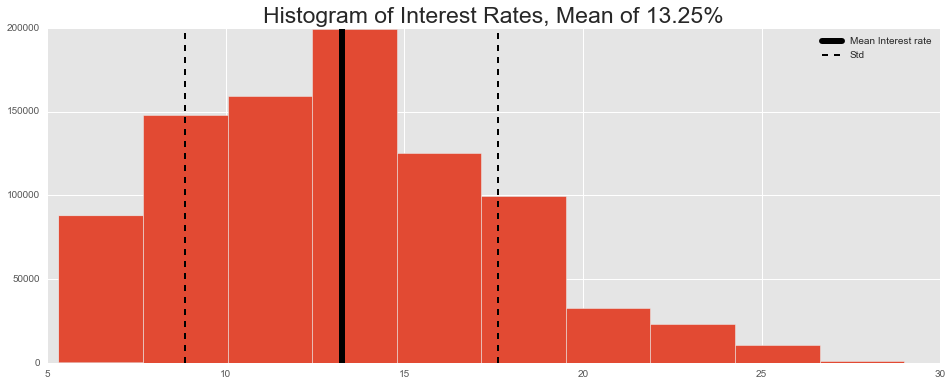

In [11]:
plt.hist(y, bins=10)  # plt.hist passes it's arguments to np.histogram
plt.axvline(np.mean(y), color='black', linestyle='-', lw=6, label='Mean Interest rate')
plt.axvline(np.mean(y) - np.std(y), color='black', linestyle='--', lw=2, label='Std')
plt.axvline(np.mean(y) + np.std(y), color='black', linestyle='--', lw=2)
plt.title("Histogram of Interest Rates, Mean of {:0.2f}%".format(np.mean(y)))
plt.legend()
plt.show()